<a href="https://colab.research.google.com/github/DrZhora/Linear-Algebra-Calculator/blob/main/Semantic_Classification_using_OpenAI_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to make Semantic Classification using OpenAI API


## Imports

In [1]:
import pandas as pd
import os
import zipfile
from matplotlib import pyplot as plt
import seaborn as sns
import openai
from sklearn.metrics import classification_report, confusion_matrix


## Loading the data from Kaggle

### 🔑 Step 1: Download `kaggle.json` from Your Kaggle Account

To access Kaggle datasets programmatically, you need to authenticate using your Kaggle API credentials.

1. Go to your [Kaggle account settings](https://www.kaggle.com/account).
2. Scroll down to the **API** section.
3. Click on **"Create New API Token"**.
4. A file named `kaggle.json` will be downloaded — it contains your Kaggle **username** and **API key**.

> ⚠️ Keep this file secure and do not share it publicly.


In [2]:
from google.colab import files
files.upload()   # Choose kaggle.json file when prompted

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"zhomko","key":"176be5beec7075fd310429ddb4bde002"}'}

In [3]:
# Make a directory and move the kaggle.json file

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the dataset using the dataset slug

!kaggle datasets download -d sahideseker/tweet-sentiment-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/sahideseker/tweet-sentiment-classification-dataset
License(s): CC-BY-SA-4.0
tweet-sentiment-classification-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# Unzip the downloaded file

!unzip tweet-sentiment-classification-dataset.zip

Archive:  tweet-sentiment-classification-dataset.zip
replace tweet_sentiment.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: tweet_sentiment.csv     


In [6]:
# Check filenames in the zip or look at contents

df = pd.read_csv("/content/tweet_sentiment.csv")
df.head()

,tweet,sentiment
0,The event starts at 5 PM.,neutral
1,I hate how this turned out.,negative
2,Fantastic experience!,positive
3,Fantastic experience!,positive
4,This is the worst thing ever!,negative


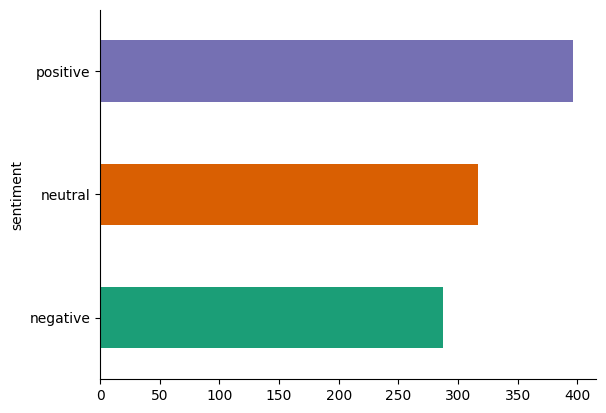

In [7]:
# Plotting the data

df.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### 💡 No Need to Train a Model

In this case, we are not training a new model — instead, we will use the pre-trained `gpt-3.5-turbo` model to make predictions.

To reduce the number of API calls (and save costs), we will sample 10% of the dataset and run predictions only on that subset.


In [8]:
df_test_sample = df.sample(frac=0.10, random_state=42)

### 🏷️ Add a New Column for Sentiment Labels

We add a new column called `'label'` and use the following encoding:
- `0` for neutral sentiment  
- `1` for positive sentiment  
- `-1` for negative sentiment  

We will request this simplified classification from the GPT model. Using numeric labels reduces the number of tokens in both the prompt and the response, which helps lower the cost of API usage.


In [9]:
df_test_sample['label'] = df_test_sample['sentiment'].apply(lambda x: 0 if x == 'neutral' else (1 if x == 'positive' else -1))
df_test_sample

,tweet,sentiment,label
521,Working from home again.,neutral,0
737,Just finished reading the article.,neutral,0
740,It’s cloudy outside.,neutral,0
660,What a wonderful day!,positive,1
411,Fantastic experience!,positive,1
...,...,...,...
436,This update made my day!,positive,1
764,This update made my day!,positive,1
88,I'm sick of this happening.,negative,-1
63,It’s cloudy outside.,neutral,0


### 🔐 Setting Up the OpenAI API Key

To use the OpenAI API, you need to provide your own API key.

1. Go to your [OpenAI account](https://platform.openai.com/account/api-keys).
2. Create a new API key if you don’t have one.
3. Copy the key and paste it into the code cell below.

> ⚠️ **Do not share your API key publicly.** Keep it secure.


In [10]:
os.environ["OPENAI_API_KEY"] = "your_api_key"

### ⚙️ Setting Up the GPT Model

You can customize the behavior of the GPT model by adjusting various parameters.

Feel free to experiment with:
- Different models (e.g., `gpt-3.5-turbo`, `gpt-4o`, etc.)
- `temperature` (controls randomness in the output)
- `max_tokens` (limits the length of the response)
- Other tuning options like `top_p`, `frequency_penalty`, and `presence_penalty`

> 🧪 Try different configurations to see how they affect the results!


In [11]:
def set_open_params(model = "gpt-3.5-turbo",
                    temperature = 0,
                    max_tokens = 10,
                    top_p= 1,
                    frequency_penalty = 0,
                    presence_penalty = 0):
    """ Set openai parameters"""

    openai_params = {}

    openai_params['model'] = model
    openai_params['temperature'] = temperature
    openai_params['max_tokens'] = max_tokens
    openai_params['top_p'] = top_p
    openai_params['frequency_penalty'] = frequency_penalty
    openai_params['presence_penalty'] = presence_penalty

    return openai_params


def get_response(params, messages):
    """ GET completion from openai api"""

    response = openai.chat.completions.create(
        model = params['model'],
        messages = messages,
        temperature = params['temperature'],
        max_tokens = params['max_tokens'],
        top_p = params['top_p'],
        frequency_penalty = params['frequency_penalty'],
        presence_penalty = params['presence_penalty'],
    )

    return response


params = set_open_params()

### 🤖 Making Predictions and Appending to the Data

We will use the GPT model to generate sentiment predictions for each text sample.  
The predicted label will be added as a new column "prediction" in the DataFrame, allowing for easy comparison with the original text.


In [12]:
for idx, row in df_test_sample.iterrows():

    tweet = row["tweet"]

    messages = [
        {"role": "system", "content": "Classify the text into 0 for neutral, -1 for negative or 1 for positive."},
        {"role": "user", "content": tweet}
    ]

    try:
        response = get_response(params, messages)
        sentiment = int(response.choices[0].message.content.strip())


        df_test_sample.at[idx, "prediction"] = sentiment

    except Exception as e:
        print(f"Error processing row {idx}: {tweet}\n{e}")
        break
        # df_sample.at[idx, "prediction"] = None

In [13]:
labels = df_test_sample["label"]
predictions = df_test_sample["prediction"]

### 📊 Calculating Classification Metrics

In [14]:

# Classification metrics
print("Classification Report:")
print(classification_report(labels, predictions, digits=3))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(labels, predictions))

Classification Report:
              precision    recall  f1-score   support

          -1      1.000     1.000     1.000        26
           0      1.000     0.735     0.847        34
           1      0.816     1.000     0.899        40

    accuracy                          0.910       100
   macro avg      0.939     0.912     0.915       100
weighted avg      0.927     0.910     0.908       100

Confusion Matrix:
[[26  0  0]
 [ 0 25  9]
 [ 0  0 40]]
